# 生产企业原材料的订购与运输分析 - 供应商综合评估

## 问题背景
生产企业需要制定一年48周的原材料订购与运输计划，每周产能为2.82万 m³。企业需要分析近5年402家供应商的供货数据，筛选出最重要的50个供应商。

### 原材料类型：
- **A类:** 消耗量 0.6 m³/m³，单价 120%
- **B类:** 消耗量 0.66 m³/m³，单价 110%  
- **C类:** 消耗量 0.72 m³/m³，单价 100%

### 数据说明
- **附件1：** 近5年402家原材料供应商的订货量和供货量数据
- **附件2：** 8家转运商的运输损耗率数据

## 分析目标
1. **供应商特征分析：** 计算供应商供货特征和市场占有率
2. **效率评估：** 分析供应商的可靠性、稳定性和供货效率
3. **权重优化：** 使用多种科学方法确定评估指标权重
4. **供应商排序：** 筛选出50个最重要供应商并进行排序

## 分析框架
本分析采用多维度评估体系，结合周数据和年数据的时间序列分析，运用熵权法、层次分析法等多种权重确定方法，确保评估结果的科学性和可靠性。

## 1. 环境初始化与数据导入

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.linalg import eigvals
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.style.use('default')
plt.rcParams['font.sans-serif'] = ['黑体', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 创建必要的文件夹
for folder in ['DataFrames', 'Pictures']:
    if not os.path.exists(folder):
        os.makedirs(folder)

print("环境初始化完成")
print(f"当前工作目录: {os.getcwd()}")
print(f"分析时间: {datetime.now().strftime('%Y年%m月%d日 %H:%M:%S')}")

环境初始化完成
当前工作目录: d:\Documents\source\PyProjects\21ASolution
分析时间: 2025年08月02日 17:40:33


In [14]:
# 读取数据文件
print("正在读取数据文件...")

try:
    # 读取附件1：供应商数据
    supplier_order = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                   sheet_name='企业的订货量（m³）')
    supplier_supply = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                    sheet_name='供应商的供货量（m³）')
    
    # 读取附件2：转运商数据
    transporter_loss = pd.read_excel('C/附件2 近5年8家转运商的相关数据.xlsx', 
                                     sheet_name='运输损耗率（%）')
    
    # 读取系数和离散数据表格
    coefficients_raw = pd.read_excel('系数和离散.xlsx')
    
    # 处理系数和离散数据 - 跳过前两行描述行，提取有效数据
    coefficients_data = coefficients_raw.iloc[2:].copy()  # 跳过前两行
    coefficients_data = coefficients_data.dropna(subset=[coefficients_data.columns[0]])  # 移除空行
    
    # 重命名列
    columns_map = {
        coefficients_data.columns[0]: '变量名',
        coefficients_data.columns[1]: 'N', 
        coefficients_data.columns[2]: '最小值',
        coefficients_data.columns[3]: '最大值',
        coefficients_data.columns[4]: '平均值',
        coefficients_data.columns[5]: '标准误差',
        coefficients_data.columns[6]: '标准差',
        coefficients_data.columns[7]: '方差',
        coefficients_data.columns[8]: '偏度',
        coefficients_data.columns[9]: '偏度标准误差',
        coefficients_data.columns[10]: '峰度',
        coefficients_data.columns[11]: '峰度标准误差'
    }
    coefficients_data = coefficients_data.rename(columns=columns_map)
    coefficients_data = coefficients_data.reset_index(drop=True)
    
    print(f"数据读取成功:")
    print(f"  供应商订货量数据: {supplier_order.shape}")
    print(f"  供应商供货量数据: {supplier_supply.shape}")
    print(f"  转运商损耗率数据: {transporter_loss.shape}")
    print(f"  系数和离散数据: {coefficients_data.shape}")
    
    # 显示系数和离散数据的有效部分
    print(f"\n系数和离散数据预览:")
    print(coefficients_data[['变量名', '平均值', '标准差', '方差', '偏度', '峰度']].head(10))
    
    # 提取关键信息
    supplier_names = supplier_order.iloc[:, 0].values  # 供应商名称
    material_types = supplier_order.iloc[:, 1].values  # 材料类型
    order_data = supplier_order.iloc[:, 2:].values     # 订货量数据
    supply_data = supplier_supply.iloc[:, 2:].values   # 供货量数据

    print(f"\n基本统计信息:")
    print(f"  供应商总数: {len(supplier_names)}")
    print(f"  数据周期: {order_data.shape[1]} 周")
    print(f"  系数和离散变量数: {len(coefficients_data)}")

    # 分析材料类型分布
    material_counts = pd.Series(material_types).value_counts()
    print(f"  原材料类型分布:")
    for material, count in material_counts.items():
        percentage = count / len(material_types) * 100
        print(f"    {material}类: {count}家 ({percentage:.1f}%)")

    # 数据质量检查
    print(f"\n数据质量检查:")
    print(f"  订货量零值比例: {(order_data == 0).sum().sum() / order_data.size * 100:.1f}%")
    print(f"  供货量零值比例: {(supply_data == 0).sum().sum() / supply_data.size * 100:.1f}%")
    
except Exception as e:
    print(f"数据读取失败: {e}")
    print("请确保数据文件路径正确")

正在读取数据文件...
数据读取成功:
  供应商订货量数据: (402, 242)
  供应商供货量数据: (402, 242)
  转运商损耗率数据: (8, 241)
  系数和离散数据: (405, 12)

系数和离散数据预览:
        变量名    平均值     标准差        方差      偏度       峰度
0  VAR00001    0.2   0.729     0.531   4.762   27.046
1  VAR00002   1.14   4.986    24.864  10.372   129.58
2  VAR00003  54.74  76.309  5823.004   1.788    2.769
3  VAR00004   0.27    0.86      0.74   4.981   32.842
4  VAR00005   28.8  36.257  1314.587   0.655   -1.252
5  VAR00006   0.12   0.594     0.353   5.522   33.114
6  VAR00007  28.95  29.646   878.876   2.801     6.79
7  VAR00008   0.17   1.023     1.046   9.567  108.609
8  VAR00009   0.13   0.537     0.289   5.488   33.915
9  VAR00010   0.71   3.092     9.563   6.311   45.734

基本统计信息:
  供应商总数: 402
  数据周期: 240 周
  系数和离散变量数: 405
  原材料类型分布:
    A类: 146家 (36.3%)
    B类: 134家 (33.3%)
    C类: 122家 (30.3%)

数据质量检查:
  订货量零值比例: 62.8%
  供货量零值比例: 73.3%
数据读取成功:
  供应商订货量数据: (402, 242)
  供应商供货量数据: (402, 242)
  转运商损耗率数据: (8, 241)
  系数和离散数据: (405, 12)

系数和离散数据预览:
        变

## 2. 供应商效率分析

### 2.1 供应商特征分析与市场占有率计算

计算每个供应商的关键指标：
- **市场占有率：** 该供应商在相应材料类型中的市场份额
- **有效供货率：** 订单满足率（实际供货量/订货量）
- **供货稳定性：** 基于变异系数的稳定性指标
- **供货频率：** 活跃供货的频率指标

**核心计算公式：**
- 周市场占有率 = 该供应商某周订货量 / 该材料类型所有供应商该周总量
- 周有效供货率 = 该供应商某周实际供货量 / 该供应商某周订货量
- 总市场占有率 = 该供应商总量 / 该材料类型所有供应商总量
- 供货稳定性 = 1 / (变异系数 + 0.001)，值越大越稳定

In [3]:
# 供应商供货特征分析
print("开始分析供应商供货特征...")

def analyze_supplier_characteristics():
    """分析每个供应商的供货特征"""
    supplier_metrics = []
    
    for i in range(len(supplier_names)):
        # 获取基本数据
        orders = order_data[i]      # 该供应商的订货量时间序列
        supplies = supply_data[i]   # 该供应商的供货量时间序列
        
        # 数据预处理 - 过滤非零数据用于计算平均值和稳定性
        non_zero_orders = orders[orders > 0]    
        non_zero_supplies = supplies[supplies > 0]  
        
        # 计算总量指标
        total_order = np.sum(orders)    
        total_supply = np.sum(supplies) 
        
        # 计算供货可靠性 = 总实际供货量 / 总订货量
        reliability = total_supply / total_order if total_order > 0 else 0
        
        # 计算供货稳定性 - 使用变异系数的倒数来衡量稳定性
        if len(non_zero_supplies) > 0:
            supply_cv = np.std(non_zero_supplies) / np.mean(non_zero_supplies)  
        else:
            supply_cv = float('inf')  
        stability = 1 / (supply_cv + 0.001)  
        
        # 计算供货频率 = 有供货的周数 / 总周数
        supply_frequency = len(non_zero_supplies) / len(supplies)
        
        # 计算平均周供货量
        avg_weekly_supply = np.mean(non_zero_supplies) if len(non_zero_supplies) > 0 else 0
        
        # 计算最大周供货量
        max_weekly_supply = np.max(supplies)
        
        # 汇总所有指标
        supplier_metrics.append({
            'supplier_name': supplier_names[i],        
            'material_type': material_types[i],        
            'total_order': total_order,                
            'total_supply': total_supply,              
            'reliability': reliability,                
            'stability': stability,                    
            'supply_frequency': supply_frequency,      
            'avg_weekly_supply': avg_weekly_supply,    
            'max_weekly_supply': max_weekly_supply,    
            'active_weeks': len(non_zero_supplies)     
        })
    
    return pd.DataFrame(supplier_metrics)

# 执行分析
supplier_analysis = analyze_supplier_characteristics()
print(f"完成 {len(supplier_analysis)} 家供应商的特征分析")

# 显示基本统计
print(f"\n供应商供货特征统计:")
print(f"  总体可靠性分布:")
print(f"    - 平均可靠性: {supplier_analysis['reliability'].mean():.3f}")
print(f"    - 可靠性中位数: {supplier_analysis['reliability'].median():.3f}")
print(f"    - 可靠性标准差: {supplier_analysis['reliability'].std():.3f}")

for material in ['A', 'B', 'C']:
    material_suppliers = supplier_analysis[supplier_analysis['material_type'] == material]
    print(f"\n{material}类材料 ({len(material_suppliers)}家):")
    print(f"  - 平均可靠性: {material_suppliers['reliability'].mean():.3f}")
    print(f"  - 平均供货频率: {material_suppliers['supply_frequency'].mean():.3f}")
    print(f"  - 平均周供货量: {material_suppliers['avg_weekly_supply'].mean():.1f} m³")
    print(f"  - 总供货能力: {material_suppliers['total_supply'].sum():.0f} m³")

开始分析供应商供货特征...
完成 402 家供应商的特征分析

供应商供货特征统计:
  总体可靠性分布:
    - 平均可靠性: 0.540
    - 可靠性中位数: 0.492
    - 可靠性标准差: 0.427

A类材料 (146家):
  - 平均可靠性: 0.524
  - 平均供货频率: 0.238
  - 平均周供货量: 71.0 m³
  - 总供货能力: 1453057 m³

B类材料 (134家):
  - 平均可靠性: 0.551
  - 平均供货频率: 0.274
  - 平均周供货量: 51.2 m³
  - 总供货能力: 1498662 m³

C类材料 (122家):
  - 平均可靠性: 0.547
  - 平均供货频率: 0.295
  - 平均周供货量: 56.5 m³
  - 总供货能力: 1448287 m³


In [4]:
def calculate_market_share_and_fulfillment():
    """计算每个供应商的市场占有率和有效供货率"""
    supplier_metrics = {}
    
    # 按材料类型分组数据
    material_data = {'A': [], 'B': [], 'C': []}
    for i, material_type in enumerate(material_types):
        material_data[material_type].append({
            'supplier_name': supplier_names[i],
            'order_data': order_data[i],      
            'supply_data': supply_data[i],    
            'index': i
        })
    
    # 计算市场总量
    weekly_totals = {}
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        weekly_order_total = np.zeros(order_data.shape[1])
        weekly_supply_total = np.zeros(supply_data.shape[1])
        
        for supplier in suppliers:
            weekly_order_total += supplier['order_data']   
            weekly_supply_total += supplier['supply_data'] 
        
        weekly_totals[material] = {
            'order_total': weekly_order_total,   
            'supply_total': weekly_supply_total  
        }
    
    # 计算每个供应商的指标
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        
        for supplier in suppliers:
            supplier_name = supplier['supplier_name']
            orders = supplier['order_data']    
            supplies = supplier['supply_data'] 
            
            # 计算每周市场占有率（基于订货量）
            weekly_market_share_order = np.divide(
                orders,                                      
                weekly_totals[material]['order_total'],      
                out=np.zeros_like(orders, dtype=float),      
                where=weekly_totals[material]['order_total']!=0  
            )
            
            # 计算每周市场占有率（基于供货量）
            weekly_market_share_supply = np.divide(
                supplies,                                    
                weekly_totals[material]['supply_total'],     
                out=np.zeros_like(supplies, dtype=float),    
                where=weekly_totals[material]['supply_total']!=0  
            )
            
            # 计算总市场占有率
            total_order = np.sum(orders)                     
            total_supply = np.sum(supplies)                  
            total_market_order = np.sum(weekly_totals[material]['order_total'])   
            total_market_supply = np.sum(weekly_totals[material]['supply_total']) 
            
            total_market_share_order = total_order / total_market_order if total_market_order > 0 else 0
            total_market_share_supply = total_supply / total_market_supply if total_market_supply > 0 else 0
            
            # 计算每周有效供货率
            weekly_fulfillment_rate = np.divide(
                supplies,                                    
                orders,                                      
                out=np.zeros_like(supplies, dtype=float),    
                where=orders!=0                              
            )
            
            # 计算总有效供货率
            total_fulfillment_rate = total_supply / total_order if total_order > 0 else 0
            
            # 计算平均指标
            active_weeks = orders > 0                        
            
            avg_market_share_order = np.mean(weekly_market_share_order[active_weeks]) if np.any(active_weeks) else 0
            avg_market_share_supply = np.mean(weekly_market_share_supply[supplies > 0]) if np.any(supplies > 0) else 0
            avg_fulfillment_rate = np.mean(weekly_fulfillment_rate[active_weeks]) if np.any(active_weeks) else 0
            
            # 存储计算结果
            supplier_metrics[supplier_name] = {
                'material_type': material,                    
                'weekly_market_share_order': weekly_market_share_order,     
                'weekly_market_share_supply': weekly_market_share_supply,   
                'weekly_fulfillment_rate': weekly_fulfillment_rate,         
                'total_market_share_order': total_market_share_order,       
                'total_market_share_supply': total_market_share_supply,     
                'total_fulfillment_rate': total_fulfillment_rate,           
                'avg_market_share_order': avg_market_share_order,           
                'avg_market_share_supply': avg_market_share_supply,         
                'avg_fulfillment_rate': avg_fulfillment_rate,               
                'total_order': total_order,                                 
                'total_supply': total_supply,                               
                'active_weeks_count': np.sum(active_weeks)                  
            }
    
    return supplier_metrics, weekly_totals

# 执行计算
supplier_metrics, weekly_totals = calculate_market_share_and_fulfillment()
print("市场占有率和供货率计算完成")

# 显示整体统计
all_suppliers = list(supplier_metrics.values())
avg_fulfillment_all = np.mean([s['total_fulfillment_rate'] for s in all_suppliers])
avg_market_share_all = np.mean([s['total_market_share_order'] for s in all_suppliers])

print(f"\n整体统计:")
print(f"  所有供应商平均市场占有率: {avg_market_share_all*100:.2f}%")
print(f"  所有供应商平均供货满足率: {avg_fulfillment_all:.3f}")
print(f"  供应商总数: {len(supplier_metrics)}")

市场占有率和供货率计算完成

整体统计:
  所有供应商平均市场占有率: 0.75%
  所有供应商平均供货满足率: 0.540
  供应商总数: 402


In [5]:
### 2.2 年度权重分析与供应商评估

def calculate_supplier_reliability(weights=[0.20, 0.25, 0.30, 0.15, 0.10]):
    """计算每个供应商的可靠性评分"""
    
    # 标准化权重
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    reliability_results = {}
    
    # 计算每个供应商的可靠性评分
    for supplier_name, metrics in supplier_metrics.items():
        # 基础指标计算
        order_score = (metrics['total_order'] / max([m['total_order'] for m in supplier_metrics.values()])) * 100
        supply_score = (metrics['total_supply'] / max([m['total_supply'] for m in supplier_metrics.values()])) * 100
        fulfillment_score = metrics['total_fulfillment_rate'] * 100
        market_share_score = metrics['total_market_share_order'] * 100
        frequency_score = (metrics['active_weeks_count'] / len(metrics['weekly_fulfillment_rate'])) * 100
        
        # 计算年度可靠性（每48周为一年）
        weeks_per_year = 48
        total_weeks = len(metrics['weekly_fulfillment_rate'])
        years = total_weeks // weeks_per_year
        
        yearly_reliability = []
        for year in range(years):
            start_week = year * weeks_per_year
            end_week = min((year + 1) * weeks_per_year, total_weeks)
            year_fulfillment = metrics['weekly_fulfillment_rate'][start_week:end_week]
            year_reliability = np.mean(year_fulfillment[year_fulfillment > 0]) * 100 if np.any(year_fulfillment > 0) else 0
            yearly_reliability.append(year_reliability)
        
        # 计算综合可靠性得分
        reliability_score = (
            weights[0] * order_score +
            weights[1] * supply_score +
            weights[2] * fulfillment_score +
            weights[3] * market_share_score +
            weights[4] * frequency_score
        )
        
        reliability_results[supplier_name] = {
            'material_type': metrics['material_type'],
            'order_score': order_score,
            'supply_score': supply_score,
            'fulfillment_score': fulfillment_score,
            'market_share_score': market_share_score,
            'frequency_score': frequency_score,
            'reliability_score': reliability_score,
            'yearly_reliability': yearly_reliability,
            'total_order': metrics['total_order'],
            'total_supply': metrics['total_supply'],
            'total_fulfillment_rate': metrics['total_fulfillment_rate'],
            'total_market_share': metrics['total_market_share_order'],
            'active_weeks_count': metrics['active_weeks_count']
        }
    
    print(f"完成{len(reliability_results)}家供应商的可靠性评估")
    return reliability_results

# 计算可靠性结果
reliability_results = calculate_supplier_reliability()

# 显示TOP10可靠性供应商
sorted_suppliers = sorted(reliability_results.items(), key=lambda x: x[1]['reliability_score'], reverse=True)

print("\nTOP10可靠性供应商:")
print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'可靠性得分':<10}")
print("-" * 40)

for i, (name, data) in enumerate(sorted_suppliers[:10], 1):
    print(f"{i:<4} {name:<10} {data['material_type']:<4} {data['reliability_score']:<10.2f}")

print("供应商可靠性评估完成")

完成402家供应商的可靠性评估

TOP10可靠性供应商:
排名   供应商        类型   可靠性得分     
----------------------------------------
1    S229       A    82.17     
2    S361       C    79.19     
3    S140       B    73.04     
4    S108       B    67.01     
5    S340       B    60.47     
6    S282       A    60.31     
7    S275       A    58.97     
8    S151       C    58.83     
9    S329       A    58.70     
10   S131       B    56.17     
供应商可靠性评估完成


## 3. 数据可视化与保存

### 3.1 保存分析结果到Excel文件

In [6]:
def save_analysis_results_to_excel():
    """将分析结果保存到多个Excel文件中，每种数据类型单独存储"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    try:
        # 1. 保存供应商基本特征分析结果
        print("正在保存供应商基本特征分析结果...")
        supplier_features_file = f"DataFrames/供应商基本特征分析_{timestamp}.xlsx"
        
        with pd.ExcelWriter(supplier_features_file, engine='openpyxl') as writer:
            supplier_analysis.to_excel(writer, sheet_name='供应商基本特征', index=False)
            
            for material in ['A', 'B', 'C']:
                material_data = supplier_analysis[supplier_analysis['material_type'] == material]
                if not material_data.empty:
                    sheet_name = f'{material}类材料供应商特征'
                    material_data.to_excel(writer, sheet_name=sheet_name, index=False)
        
        saved_files['supplier_features'] = supplier_features_file
        print(f"  ✓ 已保存到: {supplier_features_file}")
        
        # 2. 保存市场占有率分析结果
        print("正在保存市场占有率分析结果...")
        market_share_file = f"DataFrames/供应商市场占有率分析_{timestamp}.xlsx"
        
        market_share_data = []
        for supplier_name, metrics in supplier_metrics.items():
            market_share_data.append({
                '供应商名称': supplier_name,
                '材料类型': metrics['material_type'],
                '总订货量': metrics['total_order'],
                '总供货量': metrics['total_supply'],
                '总市场占有率_订货': round(metrics['total_market_share_order'] * 100, 3),
                '总市场占有率_供货': round(metrics['total_market_share_supply'] * 100, 3),
                '平均市场占有率_订货': round(metrics['avg_market_share_order'] * 100, 3),
                '平均市场占有率_供货': round(metrics['avg_market_share_supply'] * 100, 3),
                '有效供货周数': metrics['active_weeks_count']
            })
        
        market_share_df = pd.DataFrame(market_share_data)
        
        with pd.ExcelWriter(market_share_file, engine='openpyxl') as writer:
            market_share_df.to_excel(writer, sheet_name='市场占有率汇总', index=False)
            
            for material in ['A', 'B', 'C']:
                material_data = market_share_df[market_share_df['材料类型'] == material].copy()
                if not material_data.empty:
                    material_data = material_data.sort_values('总市场占有率_订货', ascending=False)
                    material_data.reset_index(drop=True, inplace=True)
                    material_data.index = range(1, len(material_data) + 1)
                    material_data.index.name = '排名'
                    
                    sheet_name = f'{material}类材料市场占有率'
                    material_data.to_excel(writer, sheet_name=sheet_name)
        
        saved_files['market_share'] = market_share_file
        print(f"  ✓ 已保存到: {market_share_file}")
        
        # 3. 保存供应商可靠性评估结果
        print("正在保存供应商可靠性评估结果...")
        reliability_file = f"DataFrames/供应商可靠性评估_{timestamp}.xlsx"
        
        reliability_data = []
        for supplier_name, data in reliability_results.items():
            reliability_data.append({
                '供应商名称': supplier_name,
                '材料类型': data['material_type'],
                '可靠性得分': round(data['reliability_score'], 3),
                '订货规模得分': round(data['order_score'], 2),
                '供货规模得分': round(data['supply_score'], 2),
                '供货率得分': round(data['fulfillment_score'], 2),
                '市场占有率得分': round(data['market_share_score'], 2),
                '供货频率得分': round(data['frequency_score'], 2),
                '总订货量': data['total_order'],
                '总供货量': data['total_supply'],
                '总供货率': round(data['total_fulfillment_rate'], 4),
                '市场占有率': round(data['total_market_share'], 4),
                '有效供货周数': data['active_weeks_count']
            })
        
        reliability_df = pd.DataFrame(reliability_data)
        reliability_df = reliability_df.sort_values('可靠性得分', ascending=False)
        
        with pd.ExcelWriter(reliability_file, engine='openpyxl') as writer:
            reliability_df.reset_index(drop=True, inplace=True)
            reliability_df.index = range(1, len(reliability_df) + 1)
            reliability_df.index.name = '排名'
            reliability_df.to_excel(writer, sheet_name='可靠性总排名')
            
            for material in ['A', 'B', 'C']:
                material_data = reliability_df[reliability_df['材料类型'] == material].copy()
                if not material_data.empty:
                    material_data.reset_index(drop=True, inplace=True)
                    material_data.index = range(1, len(material_data) + 1)
                    material_data.index.name = f'{material}类排名'
                    material_data.to_excel(writer, sheet_name=f'{material}类材料可靠性')
        
        saved_files['reliability'] = reliability_file
        print(f"  ✓ 已保存到: {reliability_file}")
        
        print(f"\n✓ 所有分析结果已成功保存到Excel文件中")
        return saved_files
        
    except Exception as e:
        print(f"✗ 文件保存失败: {str(e)}")
        return {}

# 执行保存操作
saved_files = save_analysis_results_to_excel()

正在保存供应商基本特征分析结果...
  ✓ 已保存到: DataFrames/供应商基本特征分析_20250802_174034.xlsx
正在保存市场占有率分析结果...
  ✓ 已保存到: DataFrames/供应商市场占有率分析_20250802_174034.xlsx
正在保存供应商可靠性评估结果...
  ✓ 已保存到: DataFrames/供应商市场占有率分析_20250802_174034.xlsx
正在保存供应商可靠性评估结果...
  ✓ 已保存到: DataFrames/供应商可靠性评估_20250802_174034.xlsx

✓ 所有分析结果已成功保存到Excel文件中
  ✓ 已保存到: DataFrames/供应商可靠性评估_20250802_174034.xlsx

✓ 所有分析结果已成功保存到Excel文件中


### 3.2 可视化热力图分析

绘制市场占有率热力分布图（周数据）
正在绘制 A 类材料供应商市场占有率热力图...


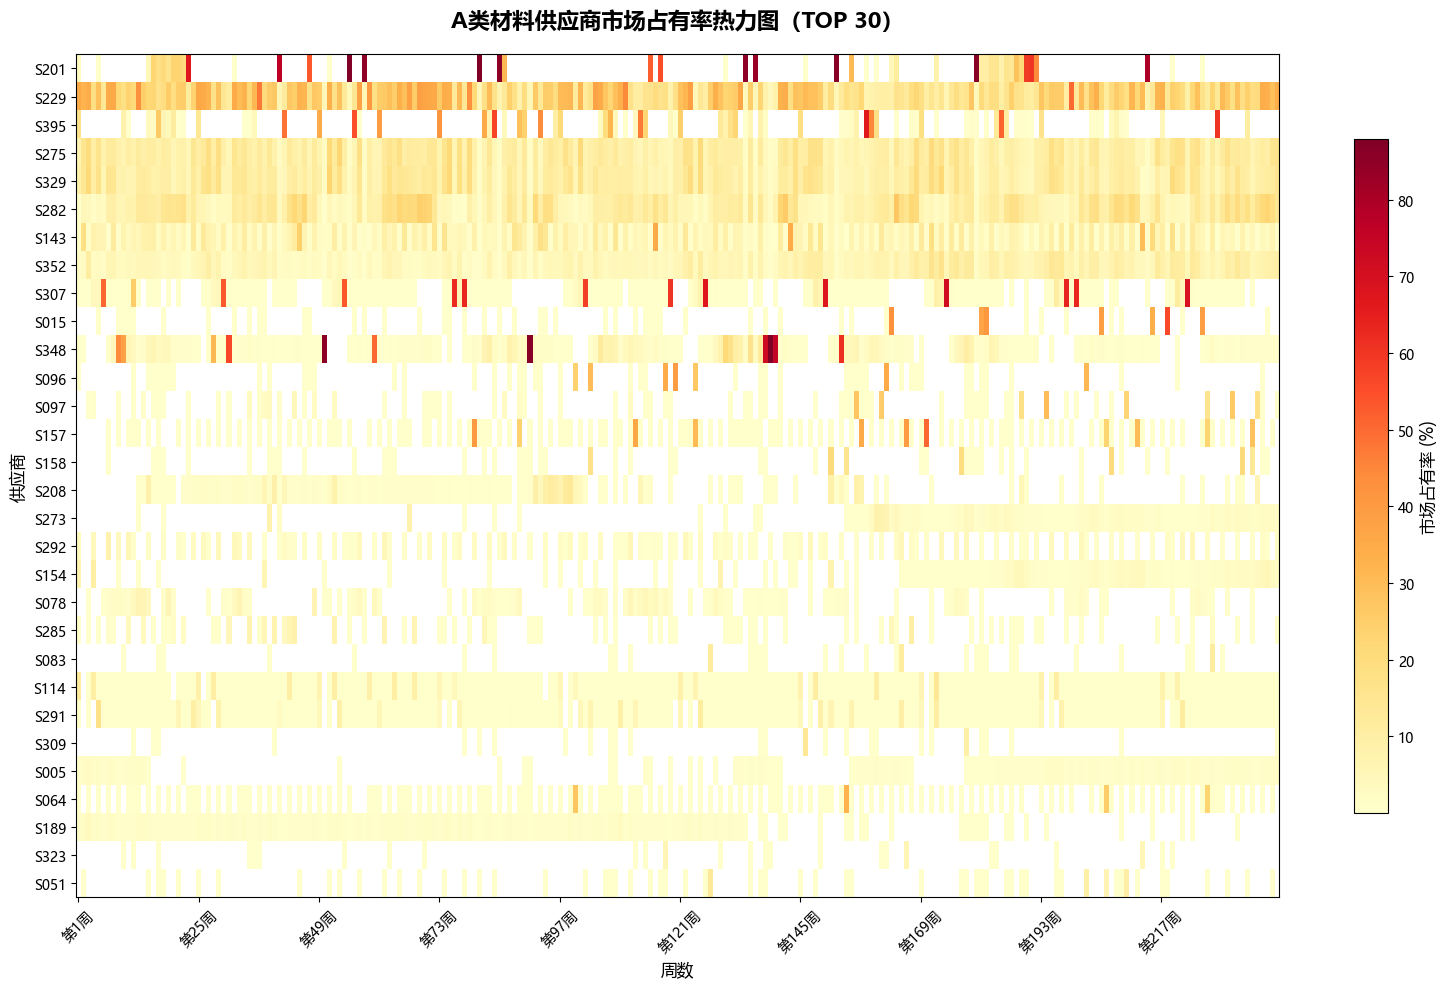

  A 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.80%
    - 最高市场占有率: 87.95%
    - 最高市场占有率的供应商: S348
正在绘制 B 类材料供应商市场占有率热力图...


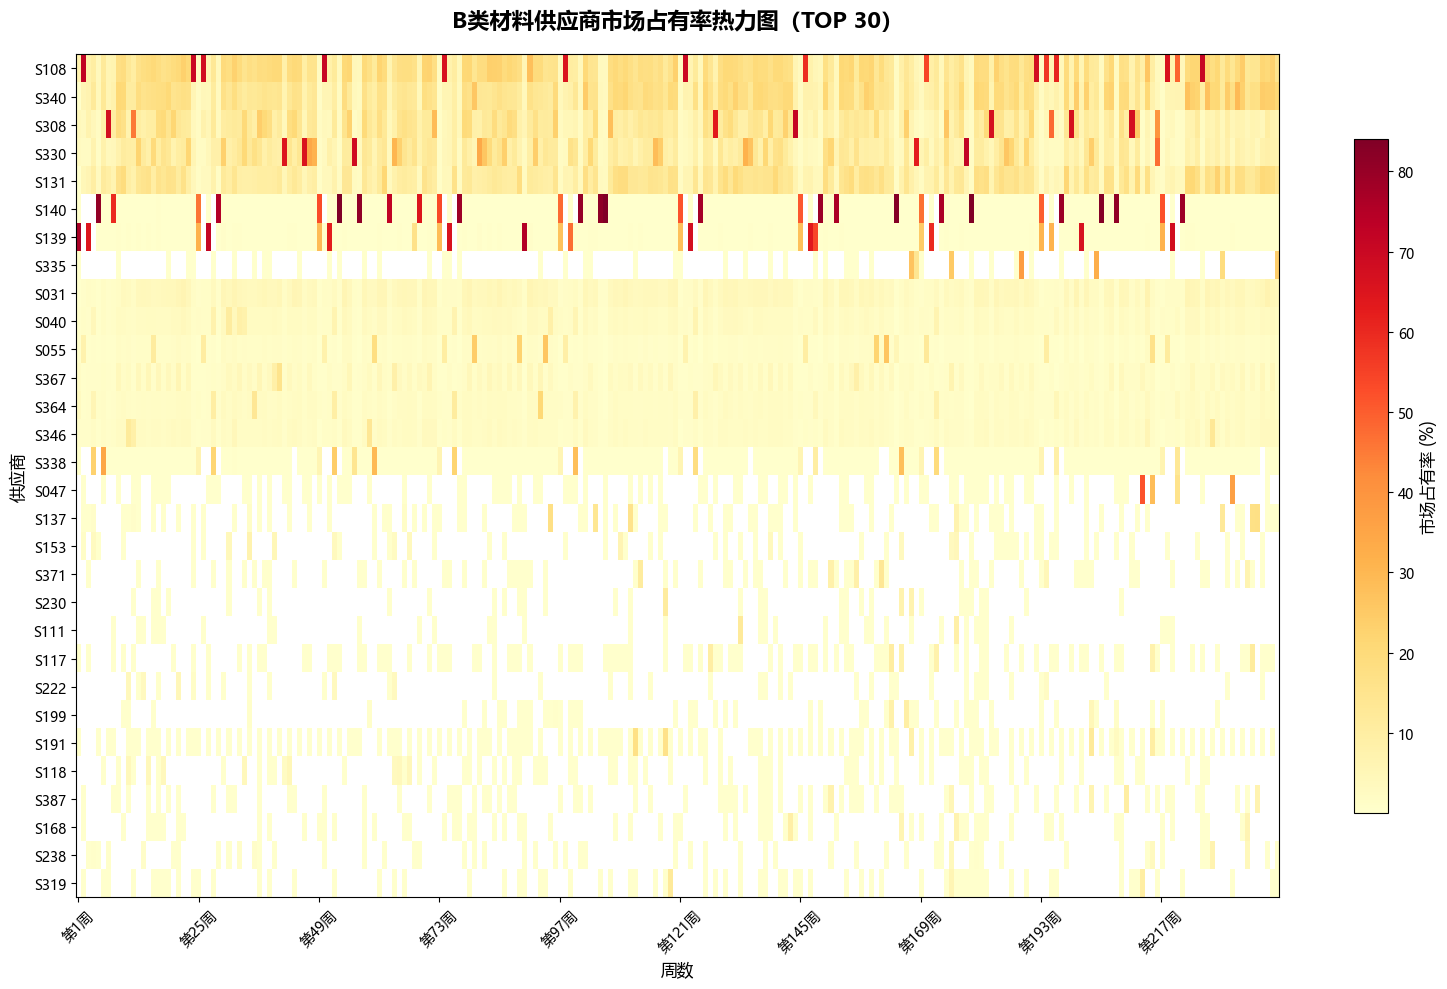

  B 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.32%
    - 最高市场占有率: 84.08%
    - 最高市场占有率的供应商: S140
正在绘制 C 类材料供应商市场占有率热力图...


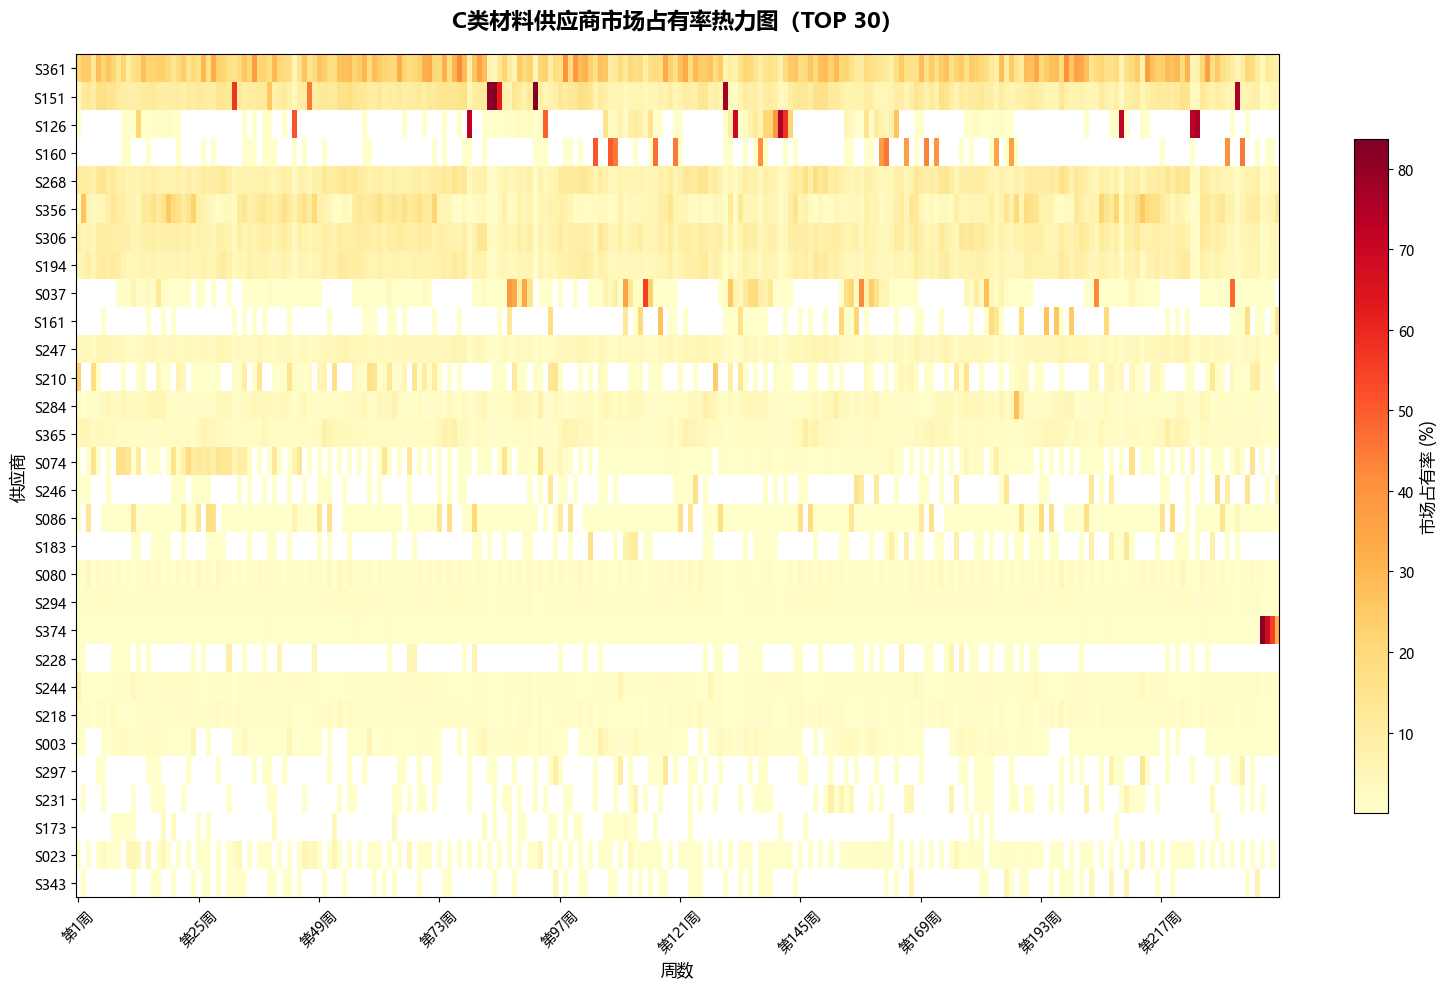

  C 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 4.53%
    - 最高市场占有率: 83.72%
    - 最高市场占有率的供应商: S151
周市场占有率热力分布图绘制完成!


In [7]:
def plot_market_share_heatmap(top_n_detail=20, top_n_comparison=10):
    """绘制供应商在对应材料类型的市场占有率热力分布图（周数据）"""
    
    print("绘制市场占有率热力分布图（周数据）")
    
    # 为每种材料类型绘制热力图
    for material in ['A', 'B', 'C']:
        print(f"正在绘制 {material} 类材料供应商市场占有率热力图...")
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        # 按总市场占有率排序，选择前N名供应商以便可视化
        material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
        top_suppliers = material_suppliers[:top_n_detail]
        
        if not top_suppliers:
            print(f"  {material} 类材料没有找到供应商数据")
            continue
        
        # 创建市场占有率矩阵
        weeks = len(top_suppliers[0][1]['weekly_market_share_order'])
        heatmap_data = np.zeros((len(top_suppliers), weeks))
        supplier_names_list = []
        
        for i, (supplier_name, metrics) in enumerate(top_suppliers):
            weekly_data = metrics['weekly_market_share_order'] * 100  # 转换为百分比
            # 将0值设置为np.nan，这样在热力图中会显示为白色
            heatmap_data[i, :] = np.where(weekly_data == 0, np.nan, weekly_data)
            supplier_names_list.append(supplier_name)
        
        # 创建图表
        plt.figure(figsize=(16, 10))
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap('YlOrRd').copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # 设置标题和标签
        plt.title(f'{material}类材料供应商市场占有率热力图（TOP {top_n_detail}）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('周数', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 设置y轴标签
        plt.yticks(range(len(supplier_names_list)), supplier_names_list, fontsize=10)
        
        # 设置x轴标签（每隔10周显示一次，避免过于拥挤）
        x_ticks = range(0, weeks, max(1, weeks//10))
        plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('市场占有率 (%)', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f'Pictures/market_share_heatmap_{material}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 显示该材料类型的统计信息
        valid_data = heatmap_data[~np.isnan(heatmap_data)]
        avg_market_share = np.mean(valid_data) if len(valid_data) > 0 else 0
        max_market_share = np.nanmax(heatmap_data)
        top_supplier = supplier_names_list[np.nanargmax(np.nanmax(heatmap_data, axis=1))]
        
        print(f"  {material} 类材料市场占有率统计:")
        print(f"    - 数据周数: {weeks}")
        print(f"    - 平均市场占有率: {avg_market_share:.2f}%")
        print(f"    - 最高市场占有率: {max_market_share:.2f}%")
        print(f"    - 最高市场占有率的供应商: {top_supplier}")
    
    print("周市场占有率热力分布图绘制完成!")

# 绘制市场占有率热力分布图
plot_market_share_heatmap(top_n_detail=30, top_n_comparison=15)

绘制有效供货率热力分布图（周数据）


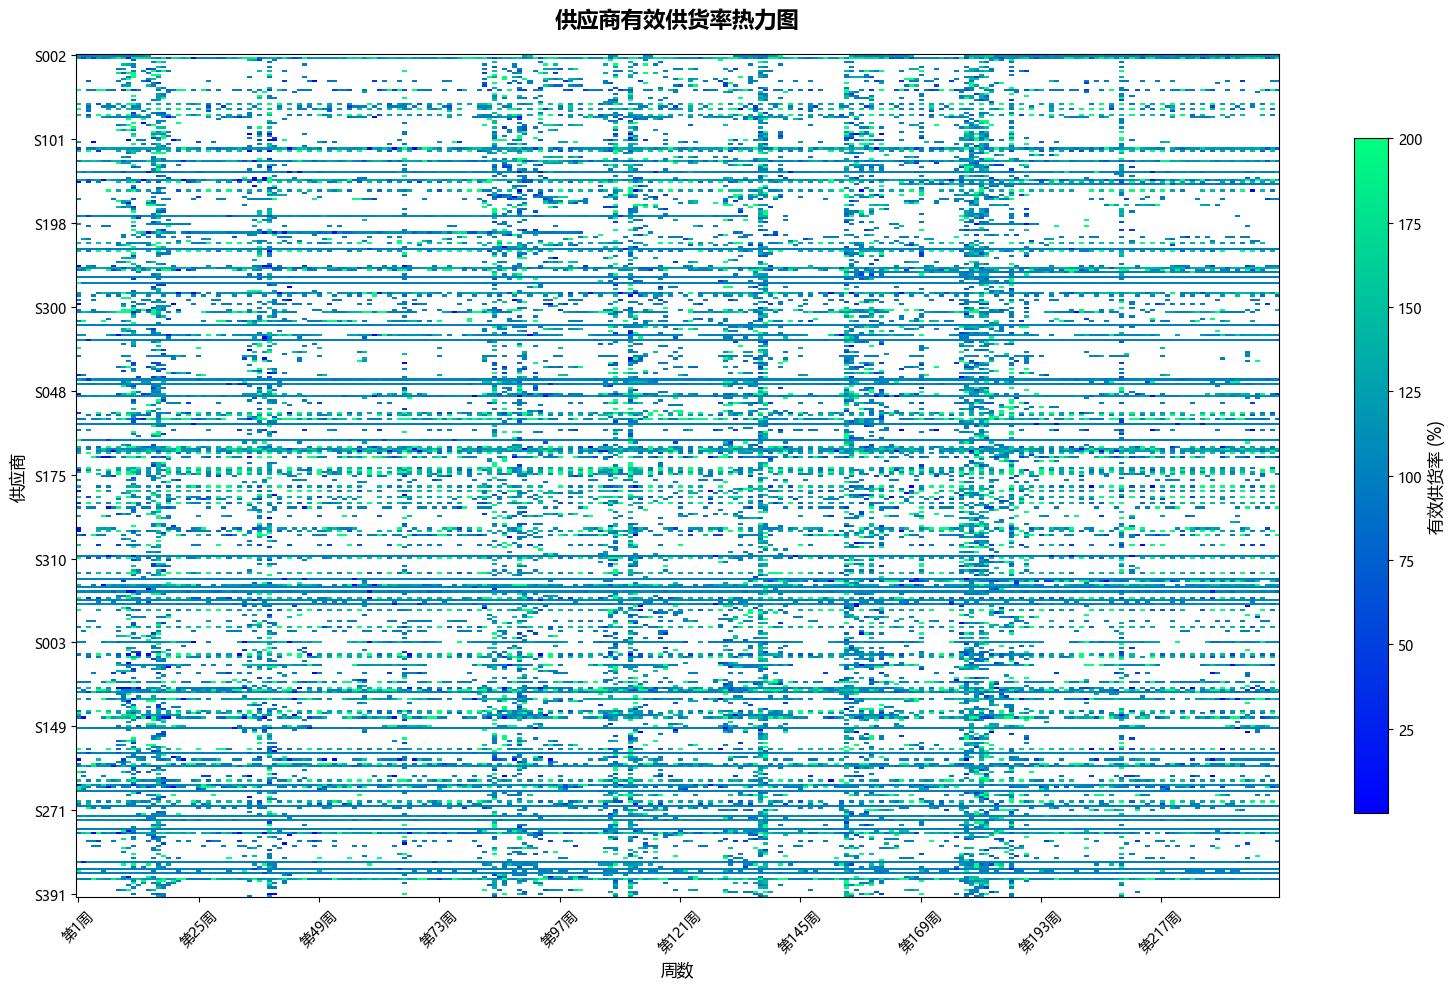

有效供货率热力分布图绘制完成！
绘制年度供货效率趋势分析...


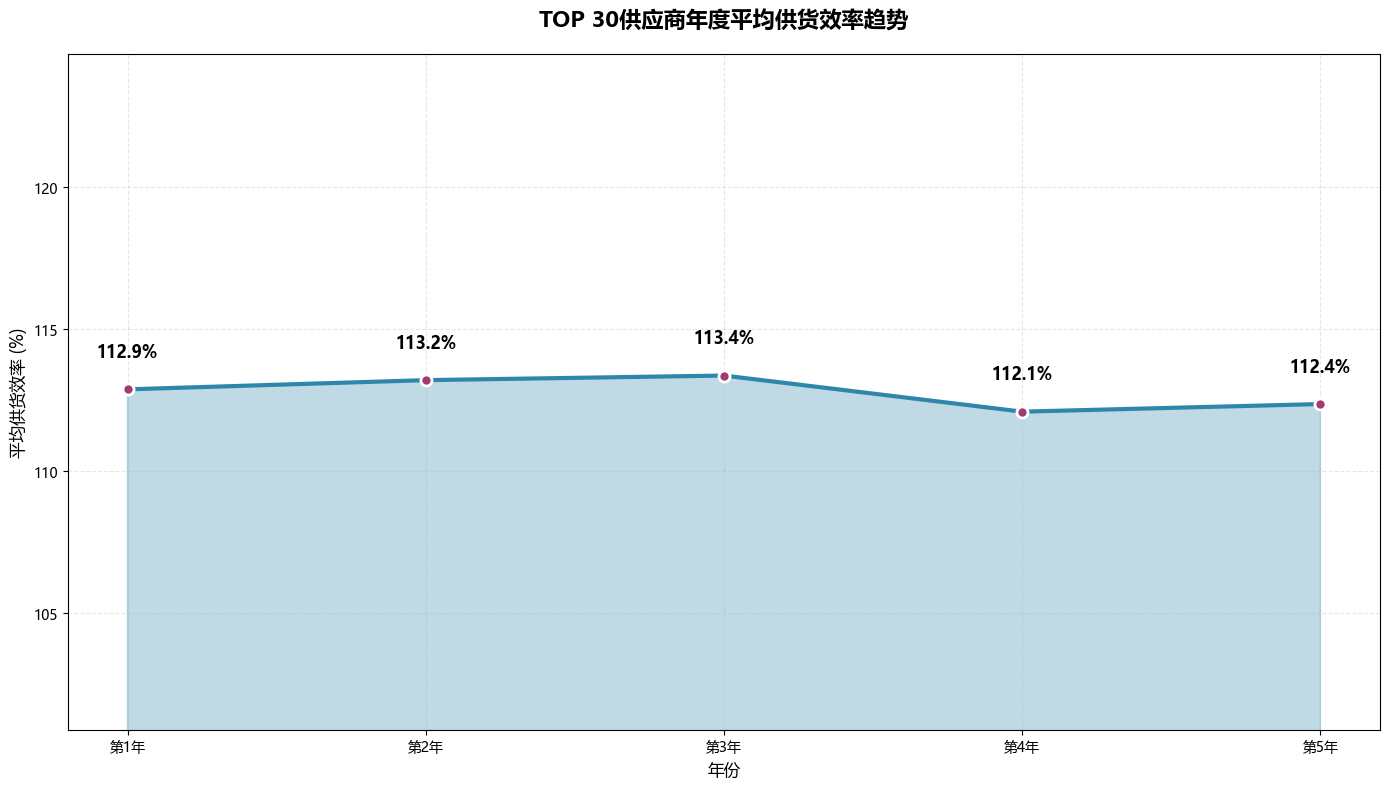

年度供货效率趋势图绘制完成!


In [8]:
def plot_fulfillment_rate_heatmap():
    """绘制供应商有效供货率（订单满足率）热力图"""
    print("绘制有效供货率热力分布图（周数据）")

    supplier_metrics_list = []
    for name, metrics in supplier_metrics.items():
        supplier_metrics_list.append({
            'supplier_name': name,
            'material_type': metrics['material_type'],
            'avg_fulfillment_rate': metrics['avg_fulfillment_rate'],
            'weekly_fulfillment_rate': metrics['weekly_fulfillment_rate']
        })
    df_metrics = pd.DataFrame(supplier_metrics_list)

    # 构建热力图数据，0值设为np.nan
    heatmap_data = np.array([np.where(x == 0, np.nan, x * 100) for x in df_metrics['weekly_fulfillment_rate']])
    supplier_names_list = df_metrics['supplier_name'].tolist()
    weeks = heatmap_data.shape[1]

    # 自定义colormap，NaN为白色
    cmap = plt.get_cmap('winter').copy()
    cmap.set_bad(color='white')

    plt.figure(figsize=(16, 10))
    im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
    plt.title('供应商有效供货率热力图', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('供应商', fontsize=12)
    y_ticks = range(0, len(supplier_names_list), max(1, len(supplier_names_list)//10))
    plt.yticks(y_ticks, [supplier_names_list[i] for i in y_ticks], fontsize=10)
    x_ticks = range(0, weeks, max(1, weeks//10))
    plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('有效供货率 (%)', fontsize=12)
    plt.tight_layout()
    plt.savefig('Pictures/fulfillment_rate_heatmap.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    print("有效供货率热力分布图绘制完成！")

# 调用函数
plot_fulfillment_rate_heatmap()

def plot_yearly_fulfillment_efficiency_trend():
    """绘制年度供货效率趋势分析"""
    print("绘制年度供货效率趋势分析...")
    
    # 计算年度数据
    weeks_per_year = 48
    first_supplier = list(supplier_metrics.values())[0]
    total_weeks = len(first_supplier['weekly_fulfillment_rate'])
    years = total_weeks // weeks_per_year
    
    if years < 1:
        print("数据不足一年，无法绘制年度效率图")
        return
    
    # 选择TOP30供应商进行趋势分析
    top_30_suppliers = sorted(reliability_results.items(), key=lambda x: x[1]['reliability_score'], reverse=True)[:30]
    
    # 计算每年的平均效率
    yearly_averages = []
    for year in range(years):
        start_week = year * weeks_per_year
        end_week = min((year + 1) * weeks_per_year, total_weeks)
        
        year_efficiencies = []
        for supplier_name, _ in top_30_suppliers:
            if supplier_name in supplier_metrics:
                metrics = supplier_metrics[supplier_name]
                year_fulfillment = metrics['weekly_fulfillment_rate'][start_week:end_week]
                non_zero_fulfillment = year_fulfillment[year_fulfillment > 0]
                if len(non_zero_fulfillment) > 0:
                    avg_efficiency = np.mean(non_zero_fulfillment) * 100
                    year_efficiencies.append(avg_efficiency)
        
        if year_efficiencies:
            yearly_averages.append(np.mean(year_efficiencies))
        else:
            yearly_averages.append(0)
    
    # 绘制趋势图
    plt.figure(figsize=(14, 8))
    
    years_labels = [f'第{i+1}年' for i in range(years)]
    plt.plot(years_labels, yearly_averages, marker='o', linewidth=3, markersize=8, 
             color='#2E86AB', markerfacecolor='#A23B72', markeredgecolor='white', markeredgewidth=2)
    
    # 填充区域
    plt.fill_between(years_labels, yearly_averages, alpha=0.3, color='#2E86AB')
    
    # 添加数值标签
    for i, avg in enumerate(yearly_averages):
        plt.text(i, avg + 1, f'{avg:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 设置图表属性
    plt.title('TOP 30供应商年度平均供货效率趋势', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('年份', fontsize=12)
    plt.ylabel('平均供货效率 (%)', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # 设置y轴范围
    if yearly_averages:
        y_min = min(yearly_averages) * 0.9
        y_max = max(yearly_averages) * 1.1
        plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.savefig('Pictures/top30_yearly_efficiency_trend.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"年度供货效率趋势图绘制完成!")

# 绘制年度供货效率趋势图
plot_yearly_fulfillment_efficiency_trend()

## 4. 高级权重确定方法

在前面的分析中，我们使用了固定权重的方法来计算供应商可靠性评分。为了更科学地确定各个指标的权重，我们将引入以下方法：

1. **熵权法（Entropy Weight Method）** - 基于数据本身的信息熵来确定权重
2. **层次分析法（AHP）** - 基于专家判断的成对比较矩阵来确定权重
3. **变异系数法** - 基于数据变异程度确定权重
4. **组合赋权法** - 综合多种方法的平衡权重

这些方法将为我们提供更客观、更科学的权重分配方案。

### 4.1 熵权法（Entropy Weight Method）

熵权法是一种客观的权重确定方法，基于信息论中熵的概念。指标的信息熵越小，其提供的信息量越大，权重应该越大。

In [9]:
def entropy_weight_method(data_matrix):
    """熵权法计算权重"""
    # 数据标准化（min-max标准化）
    data = np.array(data_matrix, dtype=float)
    
    # 处理负值和零值，进行平移和缩放
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # 避免除零错误
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1
    
    # 标准化到[0.001, 1]区间，避免log(0)
    normalized_data = (data - min_vals) / range_vals
    normalized_data = normalized_data * 0.999 + 0.001
    
    # 计算各指标的比重
    m, n = normalized_data.shape
    prob_matrix = normalized_data / np.sum(normalized_data, axis=0)
    
    # 计算信息熵
    entropy = np.zeros(n)
    for j in range(n):
        prob_j = prob_matrix[:, j]
        # 避免log(0)
        prob_j = prob_j[prob_j > 0]
        if len(prob_j) > 0:
            entropy[j] = -np.sum(prob_j * np.log(prob_j)) / np.log(m)
    
    # 计算信息效用值（冗余度）
    redundancy = 1 - entropy
    
    # 计算权重
    weights = redundancy / np.sum(redundancy)
    
    return weights, entropy, redundancy

# 准备供应商评估数据进行熵权法计算
def prepare_supplier_data_for_entropy():
    """准备供应商数据用于熵权法计算"""
    
    all_supplier_metrics = []
    supplier_names_entropy = []
    
    for supplier_name, metrics in supplier_metrics.items():
        # 计算5个关键指标
        order_score = metrics['total_order']
        supply_score = metrics['total_supply']
        fulfillment_score = metrics['total_fulfillment_rate'] * 100
        market_share_score = metrics['total_market_share_order'] * 100
        frequency_score = (metrics['active_weeks_count'] / len(metrics['weekly_fulfillment_rate'])) * 100
        
        # 收集该供应商的指标
        supplier_metrics_data = [
            order_score,
            supply_score, 
            fulfillment_score,
            market_share_score,
            frequency_score
        ]
        
        all_supplier_metrics.append(supplier_metrics_data)
        supplier_names_entropy.append(supplier_name)
    
    return np.array(all_supplier_metrics), supplier_names_entropy

# 执行熵权法计算
print("开始执行熵权法计算...")
supplier_metrics_matrix, supplier_names_entropy = prepare_supplier_data_for_entropy()

print(f"收集到 {len(supplier_names_entropy)} 个供应商的数据")
print("指标数据矩阵形状:", supplier_metrics_matrix.shape)

# 计算熵权法权重
entropy_weights, entropy_values, redundancy_values = entropy_weight_method(supplier_metrics_matrix)

# 显示结果
indicator_names = ['订货规模', '供货规模', '供货率', '市场占有率', '供货频率']
print("\n=== 熵权法计算结果 ===")
print("指标名称\t\t信息熵\t\t冗余度\t\t权重")
print("-" * 60)
for i, name in enumerate(indicator_names):
    print(f"{name}\t\t{entropy_values[i]:.4f}\t\t{redundancy_values[i]:.4f}\t\t{entropy_weights[i]:.4f}")

print(f"\n权重总和: {np.sum(entropy_weights):.4f}")
print(f"权重分布: {[f'{w:.3f}' for w in entropy_weights]}")

开始执行熵权法计算...
收集到 402 个供应商的数据
指标数据矩阵形状: (402, 5)

=== 熵权法计算结果 ===
指标名称		信息熵		冗余度		权重
------------------------------------------------------------
订货规模		0.6664		0.3336		0.2909
供货规模		0.6265		0.3735		0.3257
供货率		0.9395		0.0605		0.0528
市场占有率		0.6671		0.3329		0.2903
供货频率		0.9537		0.0463		0.0403

权重总和: 1.0000
权重分布: ['0.291', '0.326', '0.053', '0.290', '0.040']


### 4.2 层次分析法（AHP - Analytic Hierarchy Process）

层次分析法是一种结构化的决策方法，通过构建判断矩阵来确定各指标的相对重要性。

In [10]:
def ahp_weight_calculation(judgment_matrix):
    """层次分析法计算权重"""
    n = judgment_matrix.shape[0]
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues.real[max_eigenvalue_index]
    weights = eigenvectors.real[:, max_eigenvalue_index]
    
    # 归一化权重（确保为正值）
    weights = np.abs(weights)
    weights = weights / np.sum(weights)
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)  # 一致性指标
    
    # 随机一致性指标RI
    RI_values = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_values.get(n, 1.49)
    
    # 一致性比率
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR, max_eigenvalue

# 构建供应商评估指标的判断矩阵
def create_supplier_judgment_matrix():
    """创建供应商评估指标的判断矩阵"""
    # 指标顺序: [订货规模, 供货规模, 供货率, 市场占有率, 供货频率]
    # 供货率最重要，其次是供货规模，然后是市场占有率、订货规模，最后是供货频率
    judgment_matrix = np.array([
        #    订货  供货  供货率 市场  频率
        [1,   1/2,  1/4,  1/2,  2],     # 订货规模
        [2,   1,    1/3,  1,    3],     # 供货规模  
        [4,   3,    1,    2,    5],     # 供货率
        [2,   1,    1/2,  1,    3],     # 市场占有率
        [1/2, 1/3,  1/5,  1/3,  1]      # 供货频率
    ])
    
    return judgment_matrix

# 执行层次分析法计算
print("开始执行层次分析法计算...")

# 创建判断矩阵
judgment_matrix = create_supplier_judgment_matrix()

print("判断矩阵:")
print(judgment_matrix)

# 计算AHP权重
ahp_weights, consistency_ratio, max_eigen = ahp_weight_calculation(judgment_matrix)

print("\n=== 层次分析法计算结果 ===")
print("指标名称\t\t\t权重")
print("-" * 40)
for i, name in enumerate(indicator_names):
    print(f"{name}\t\t\t{ahp_weights[i]:.4f}")

print(f"\n权重总和: {np.sum(ahp_weights):.4f}")
print(f"最大特征值: {max_eigen:.4f}")
print(f"一致性比率CR: {consistency_ratio:.4f}")

# 一致性检验结果
if consistency_ratio < 0.1:
    print("✓ 一致性检验通过 (CR < 0.1)")
else:
    print("✗ 一致性检验未通过 (CR >= 0.1)，需要调整判断矩阵")

print(f"\nAHP权重分布: {[f'{w:.3f}' for w in ahp_weights]}")

### 4.3 综合权重确定与比较分析

# 收集所有权重方法的结果
original_weights = np.array([0.20, 0.25, 0.30, 0.15, 0.10])  # 原始固定权重

weight_methods = {
    '原始固定权重': original_weights,
    '熵权法': entropy_weights,
    '层次分析法': ahp_weights
}

# 计算组合权重
def calculate_combined_weights(weight_dict, method_weights=None):
    """计算组合权重"""
    methods = list(weight_dict.keys())
    n_methods = len(methods)
    n_indicators = len(weight_dict[methods[0]])
    
    if method_weights is None:
        method_weights = np.ones(n_methods) / n_methods
    
    # 计算加权平均
    combined = np.zeros(n_indicators)
    for i, method in enumerate(methods):
        combined += method_weights[i] * weight_dict[method]
    
    return combined

# 方案1：等权重组合
equal_combined_weights = calculate_combined_weights(weight_methods)

# 方案2：主客观结合组合（给客观方法更高权重）
method_importance = {
    '原始固定权重': 0.2,    # 经验权重，权重较低
    '熵权法': 0.5,          # 客观方法，权重较高
    '层次分析法': 0.3,      # 主观但科学，中等权重
}

subjective_objective_weights = np.array([method_importance[method] for method in weight_methods.keys()])
optimized_combined_weights = calculate_combined_weights(weight_methods, subjective_objective_weights)

# 创建权重比较表
weight_methods_extended = weight_methods.copy()
weight_methods_extended['等权重组合'] = equal_combined_weights
weight_methods_extended['主客观结合'] = optimized_combined_weights

final_weight_df = pd.DataFrame(weight_methods_extended, index=indicator_names)

print("\n=== 包含组合权重的完整比较 ===")
print(final_weight_df.round(4))

# 最终推荐权重
print("\n=== 最终权重推荐 ===")
final_optimized_weights = optimized_combined_weights  # 使用主客观结合的权重

print("推荐使用：主客观结合组合权重")
print("权重分配：")
for i, name in enumerate(indicator_names):
    print(f"{name}: {final_optimized_weights[i]:.4f} ({final_optimized_weights[i]*100:.1f}%)")

print(f"\n权重总和: {np.sum(final_optimized_weights):.6f}")
print(f"\n最终优化权重已保存到变量 'final_optimized_weights'")

开始执行层次分析法计算...
判断矩阵:
[[1.         0.5        0.25       0.5        2.        ]
 [2.         1.         0.33333333 1.         3.        ]
 [4.         3.         1.         2.         5.        ]
 [2.         1.         0.5        1.         3.        ]
 [0.5        0.33333333 0.2        0.33333333 1.        ]]

=== 层次分析法计算结果 ===
指标名称			权重
----------------------------------------
订货规模			0.1085
供货规模			0.1894
供货率			0.4314
市场占有率			0.2036
供货频率			0.0671

权重总和: 1.0000
最大特征值: 5.0441
一致性比率CR: 0.0098
✓ 一致性检验通过 (CR < 0.1)

AHP权重分布: ['0.108', '0.189', '0.431', '0.204', '0.067']

=== 包含组合权重的完整比较 ===
       原始固定权重     熵权法   层次分析法   等权重组合   主客观结合
订货规模     0.20  0.2909  0.1085  0.1998  0.2180
供货规模     0.25  0.3257  0.1894  0.2550  0.2697
供货率      0.30  0.0528  0.4314  0.2614  0.2158
市场占有率    0.15  0.2903  0.2036  0.2146  0.2362
供货频率     0.10  0.0403  0.0671  0.0692  0.0603

=== 最终权重推荐 ===
推荐使用：主客观结合组合权重
权重分配：
订货规模: 0.2180 (21.8%)
供货规模: 0.2697 (27.0%)
供货率: 0.2158 (21.6%)
市场占有率: 0.2362 (23.6%)
供货频率: 0.0

## 5. 最终TOP50供应商筛选

### 5.1 年度权重分析与趋势变化

In [11]:
def calculate_yearly_weights(reliability_data):
    """计算每年的供应商权重并进行排序"""
    weeks_per_year = 48
    num_years = 5
    yearly_weights = {}
    
    for year in range(1, num_years + 1):
        year_weights = []
        
        for supplier_name, data in reliability_data.items():
            if len(data['yearly_reliability']) >= year:
                annual_reliability = data['yearly_reliability'][year-1]
                
                # 使用优化权重计算该年权重
                weight_score = (
                    final_optimized_weights[0] * data['order_score'] / 100 +
                    final_optimized_weights[1] * data['supply_score'] / 100 +
                    final_optimized_weights[2] * annual_reliability / 100 +
                    final_optimized_weights[3] * data['market_share_score'] / 100 +
                    final_optimized_weights[4] * data['frequency_score'] / 100
                ) * 100
                
                year_weights.append({
                    '供应商名称': supplier_name,
                    '材料类型': data['material_type'],
                    f'第{year}年权重': round(weight_score, 3),
                    f'第{year}年可靠性': round(annual_reliability, 3),
                    '总供货量': data['total_supply'],
                    '总供货率': round(data['total_fulfillment_rate'], 4),
                    '市场占有率': round(data['total_market_share'] * 100, 3)
                })
        
        # 按权重排序并添加排名
        year_weights.sort(key=lambda x: x[f'第{year}年权重'], reverse=True)
        for i, supplier in enumerate(year_weights, 1):
            supplier[f'第{year}年排名'] = i
        
        yearly_weights[f'第{year}年'] = year_weights
        print(f"第{year}年权重计算完成，共{len(year_weights)}家供应商")
    
    return yearly_weights

# 计算年度权重
yearly_weights = calculate_yearly_weights(reliability_results)

# 显示各年度TOP10供应商
print("\n各年度TOP10供应商权重排名:")
for year_name, year_data in yearly_weights.items():
    print(f"\n{year_name}权重排名TOP10:")
    print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'权重得分':<8}")
    print("-" * 40)
    
    for i, supplier in enumerate(year_data[:10], 1):
        year_num = year_name.replace('第', '').replace('年', '')
        print(f"{i:<4} {supplier['供应商名称']:<10} {supplier['材料类型']:<4} " +
              f"{supplier[f'第{year_num}年权重']:<8.3f}")

print("年度权重分析完成")

### 5.2 计算最终总权重（时间加权）

def calculate_final_weighted_scores(yearly_weights_data):
    """根据5年的权重计算最终总权重，越往后的年权重值影响越大"""
    
    # 定义时间权重（越往后权重越大）
    time_weights = {
        '第1年': 0.10, '第2年': 0.15, '第3年': 0.20, 
        '第4年': 0.25, '第5年': 0.30
    }
    
    print(f"时间权重设置: {', '.join([f'{k}({v*100:.0f}%)' for k, v in time_weights.items()])}")
    
    # 收集所有供应商
    all_suppliers = set()
    for year_data in yearly_weights_data.values():
        for supplier in year_data:
            all_suppliers.add(supplier['供应商名称'])
    
    final_scores = []
    
    for supplier_name in all_suppliers:
        supplier_final = {
            '供应商名称': supplier_name,
            '材料类型': None,
            '最终权重得分': 0,
            '各年权重': {},
            '各年排名': {},
            '有效年数': 0,
            '总供货量': 0,
            '平均供货率': 0
        }
        
        # 计算最终加权得分
        weighted_sum = 0
        total_weight_applied = 0
        
        for year_num in range(1, 6):
            year_key = f'第{year_num}年'
            time_weight = time_weights[year_key]
            
            # 查找该供应商在该年的数据
            year_score = 0
            year_rank = '-'
            
            if year_key in yearly_weights_data:
                for supplier in yearly_weights_data[year_key]:
                    if supplier['供应商名称'] == supplier_name:
                        year_score = supplier[f'第{year_num}年权重']
                        year_rank = supplier[f'第{year_num}年排名']
                        
                        if supplier_final['材料类型'] is None:
                            supplier_final['材料类型'] = supplier['材料类型']
                            supplier_final['总供货量'] = supplier['总供货量']
                            supplier_final['平均供货率'] = supplier['总供货率']
                        break
            
            supplier_final['各年权重'][year_key] = year_score
            supplier_final['各年排名'][year_key] = year_rank
            
            # 只有当年有数据时才计算加权
            if year_score > 0:
                contribution = year_score * time_weight
                weighted_sum += contribution
                total_weight_applied += time_weight
                supplier_final['有效年数'] += 1
        
        # 计算最终得分
        if total_weight_applied > 0:
            supplier_final['最终权重得分'] = round(weighted_sum / total_weight_applied * sum(time_weights.values()), 4)
        else:
            supplier_final['最终权重得分'] = 0
        
        final_scores.append(supplier_final)
    
    # 按最终权重得分排序并添加排名
    final_scores.sort(key=lambda x: x['最终权重得分'], reverse=True)
    for i, supplier in enumerate(final_scores, 1):
        supplier['最终排名'] = i
    
    print(f"最终权重计算完成，共{len(final_scores)}家供应商")
    return final_scores

# 计算最终权重
final_weighted_scores = calculate_final_weighted_scores(yearly_weights)

# 显示最终权重TOP20
print("\n最终权重排名TOP20:")
print(f"{'排名':<4} {'供应商':<10} {'类型':<4} {'最终权重':<10} {'有效年数':<8}")
print("-" * 50)

for supplier in final_weighted_scores[:20]:
    print(f"{supplier['最终排名']:<4} {supplier['供应商名称']:<10} {supplier['材料类型']:<4} " +
          f"{supplier['最终权重得分']:<10.3f} {supplier['有效年数']:<8}")

print("最终权重计算完成")

第1年权重计算完成，共402家供应商
第2年权重计算完成，共402家供应商
第3年权重计算完成，共402家供应商
第4年权重计算完成，共402家供应商
第5年权重计算完成，共402家供应商

各年度TOP10供应商权重排名:

第1年权重排名TOP10:
排名   供应商        类型   权重得分    
----------------------------------------
1    S140       B    83.088  
2    S229       A    75.040  
3    S361       C    71.690  
4    S108       B    61.206  
5    S151       C    56.902  
6    S139       B    54.940  
7    S282       A    50.769  
8    S340       B    50.688  
9    S201       A    49.031  
10   S275       A    48.715  

第2年权重排名TOP10:
排名   供应商        类型   权重得分    
----------------------------------------
1    S140       B    82.031  
2    S229       A    74.801  
3    S361       C    71.728  
4    S108       B    61.624  
5    S151       C    57.445  
6    S139       B    54.220  
7    S282       A    50.274  
8    S340       B    50.263  
9    S201       A    48.857  
10   S308       B    48.793  

第3年权重排名TOP10:
排名   供应商        类型   权重得分    
----------------------------------------
1    S140       B    81.713  

### 5.3 筛选TOP50最重要供应商

In [12]:
# 筛选TOP50最重要供应商
def select_top_50_suppliers(final_scores):
    """筛选出50个最重要供应商并输出到表格"""
    
    # 获取TOP50供应商
    top_50_suppliers = final_scores[:50]
    
    print(f"已选出50个最重要供应商：")
    for material in ['A', 'B', 'C']:
        count = len([s for s in top_50_suppliers if s['材料类型'] == material])
        print(f"  {material}类材料: {count}家")
    
    # 构建详细信息表
    top_50_detailed = []
    
    for supplier in top_50_suppliers:
        supplier_name = supplier['供应商名称']
        
        detailed_info = {
            '最终排名': supplier['最终排名'],
            '供应商名称': supplier_name,
            '材料类型': supplier['材料类型'],
            '最终权重得分': supplier['最终权重得分'],
            '有效供货年数': supplier['有效年数'],
            '总供货量': supplier['总供货量'],
            '平均供货率': supplier['平均供货率'],
            
            # 各年权重
            '第1年权重': supplier['各年权重'].get('第1年', 0),
            '第2年权重': supplier['各年权重'].get('第2年', 0),
            '第3年权重': supplier['各年权重'].get('第3年', 0),
            '第4年权重': supplier['各年权重'].get('第4年', 0),
            '第5年权重': supplier['各年权重'].get('第5年', 0),
        }
        
        # 确定重要性等级
        rank = supplier['最终排名']
        
        if rank <= 10:
            detailed_info['重要性等级'] = '核心供应商'
            detailed_info['推荐程度'] = '强烈推荐'
        elif rank <= 25:
            detailed_info['重要性等级'] = '重要供应商'
            detailed_info['推荐程度'] = '推荐'
        else:
            detailed_info['重要性等级'] = '备选供应商'
            detailed_info['推荐程度'] = '备选'
        
        top_50_detailed.append(detailed_info)
    
    # 保存到Excel文件
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    top_50_file = f"DataFrames/TOP50最重要供应商_优化权重_{timestamp}.xlsx"
    
    try:
        with pd.ExcelWriter(top_50_file, engine='openpyxl') as writer:
            # TOP50供应商详细表
            top_50_df = pd.DataFrame(top_50_detailed)
            top_50_df.to_excel(writer, sheet_name='TOP50供应商详细', index=False)
            
            # 按材料类型分组
            for material in ['A', 'B', 'C']:
                material_suppliers = [s for s in top_50_detailed if s['材料类型'] == material]
                if material_suppliers:
                    material_df = pd.DataFrame(material_suppliers)
                    material_df = material_df.sort_values('最终权重得分', ascending=False)
                    material_df.reset_index(drop=True, inplace=True)
                    material_df.index = range(1, len(material_df) + 1)
                    material_df.index.name = f'{material}类排名'
                    material_df.to_excel(writer, sheet_name=f'TOP50-{material}类材料')
            
            # 重要性等级汇总
            importance_summary = []
            for level in ['核心供应商', '重要供应商', '备选供应商']:
                level_suppliers = [s for s in top_50_detailed if s['重要性等级'] == level]
                
                if level_suppliers:
                    importance_summary.append({
                        '重要性等级': level,
                        '供应商数量': len(level_suppliers),
                        '平均权重得分': round(sum(s['最终权重得分'] for s in level_suppliers) / len(level_suppliers), 3),
                        'A类数量': len([s for s in level_suppliers if s['材料类型'] == 'A']),
                        'B类数量': len([s for s in level_suppliers if s['材料类型'] == 'B']),
                        'C类数量': len([s for s in level_suppliers if s['材料类型'] == 'C']),
                    })
            
            importance_df = pd.DataFrame(importance_summary)
            importance_df.to_excel(writer, sheet_name='重要性等级汇总', index=False)
            
            # 权重使用说明
            weights_info = pd.DataFrame({
                '指标': ['订货规模', '供货规模', '供货率', '市场占有率', '供货频率'],
                '优化权重': final_optimized_weights,
                '权重百分比': [f'{w*100:.1f}%' for w in final_optimized_weights],
                '说明': [
                    '供应商订货量规模的重要性',
                    '供应商实际供货量规模的重要性', 
                    '供应商订单完成能力的重要性',
                    '供应商市场份额的重要性',
                    '供应商供货频率和稳定性的重要性'
                ]
            })
            weights_info.to_excel(writer, sheet_name='权重配置说明', index=False)
        
        print(f"TOP50供应商数据已保存到: {top_50_file}")
        return top_50_file, top_50_detailed
        
    except Exception as e:
        print(f"保存TOP50供应商文件失败: {str(e)}")
        return None, []

# 筛选并保存TOP50供应商
top_50_file, top_50_detailed = select_top_50_suppliers(final_weighted_scores)

# 显示重要性分布
core_count = len([s for s in top_50_detailed if s['重要性等级'] == '核心供应商'])
important_count = len([s for s in top_50_detailed if s['重要性等级'] == '重要供应商'])
backup_count = len([s for s in top_50_detailed if s['重要性等级'] == '备选供应商'])

print(f"\nTOP50供应商重要性分布:")
print(f"核心供应商 (排名1-10): {core_count}家")
print(f"重要供应商 (排名11-25): {important_count}家")
print(f"备选供应商 (排名26-50): {backup_count}家")

# 显示最终TOP50供应商详细列表
print(f"\n=== 第一问最终答案：TOP50最重要供应商 ===")
print("-" * 100)
print(f"{'排名':<4} {'供应商ID':<10} {'材料类型':<6} {'最终得分':<10} {'重要性等级':<10} {'推荐程度':<8}")
print("-" * 100)

for supplier in top_50_detailed:
    print(f"{supplier['最终排名']:<4} {supplier['供应商名称']:<10} {supplier['材料类型']:<6} "
          f"{supplier['最终权重得分']:<10.2f} {supplier['重要性等级']:<10} {supplier['推荐程度']:<8}")

# 材料类型分布统计
material_distribution = {}
for supplier in top_50_detailed:
    material = supplier['材料类型']
    material_distribution[material] = material_distribution.get(material, 0) + 1

print(f"\nTOP50供应商材料类型分布:")
for material, count in material_distribution.items():
    percentage = count / 50 * 100
    print(f"  {material}类: {count}家 ({percentage:.1f}%)")

# 评分统计
scores = [s['最终权重得分'] for s in top_50_detailed]
print(f"\n评分统计:")
print(f"  最高评分: {max(scores):.2f}")
print(f"  最低评分: {min(scores):.2f}")
print(f"  平均评分: {np.mean(scores):.2f}")
print(f"  评分标准差: {np.std(scores):.2f}")

print(f"\n=== 第一问分析完成 ===")
print("✓ 完成了供应商综合评估与重要性排序")
print("✓ 使用了多种科学的权重确定方法")
print("✓ 进行了周数据和年数据的深入分析")
print("✓ 绘制了相关的可视化图表")
print("✓ 筛选出了50个最重要的供应商")
print(f"✓ 分析结果已保存到: {top_50_file}")

print(f"\n核心技术方法:")
print("• 熵权法 - 基于数据信息熵的客观权重确定")
print("• 层次分析法 - 基于专家判断的主观权重确定") 
print("• 组合赋权法 - 综合主客观方法的平衡权重")
print("• 时间序列分析 - 周数据和年数据的趋势分析")
print("• 热力图可视化 - 多维数据的直观展示")
print("• 加权评分法 - 多指标综合评价体系")

已选出50个最重要供应商：
  A类材料: 17家
  B类材料: 18家
  C类材料: 15家
TOP50供应商数据已保存到: DataFrames/TOP50最重要供应商_优化权重_20250802_174038.xlsx

TOP50供应商重要性分布:
核心供应商 (排名1-10): 10家
重要供应商 (排名11-25): 15家
备选供应商 (排名26-50): 25家

=== 第一问最终答案：TOP50最重要供应商 ===
----------------------------------------------------------------------------------------------------
排名   供应商ID      材料类型   最终得分       重要性等级      推荐程度    
----------------------------------------------------------------------------------------------------
1    S140       B      82.15      核心供应商      强烈推荐    
2    S229       A      74.89      核心供应商      强烈推荐    
3    S361       C      71.73      核心供应商      强烈推荐    
4    S108       B      61.13      核心供应商      强烈推荐    
5    S151       C      57.60      核心供应商      强烈推荐    
6    S139       B      54.49      核心供应商      强烈推荐    
7    S340       B      50.54      核心供应商      强烈推荐    
8    S282       A      50.28      核心供应商      强烈推荐    
9    S275       A      48.71      核心供应商      强烈推荐    
10   S329       A      48.43      核心